In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
import torch
from generation import sample_model_N_times
from utils import plot_velocity_models, plot_wiggle_traces

Populating the interactive namespace from numpy and matplotlib


# Reproducing Roeth and Tarantola using Modern Tools
---
## Part 2: Forward Modeling Acoustic Waveforms with Devito

In the last instance of this blog series we created a probabilistic model of the horizontal layers with a random distribution of acoustic velocities based on the paper by [Roeth and Tarantola](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/93JB01563).

In this blog post, we will make use of an existing library for fast finite-difference computation to forward model the acoustic wave-equation given the a set of models that we will generate.

In the following we will reuse the parameters that we've determined from the publication and in the first blog post entry to generate individual earth models. Roeth and Tarantola created 450 models, with nine layers, as a training set and 150 additional models as a test set.

In the following we will reuse the function definitions from the first blog entry to generate a number of earth models for training and test sets. 

In [2]:
dx = 5.0
dz = 40
nz = 360
ny = 500

v0 = 1500
v_max = 4000
dv_l_const = 190.
n_layers = 9

## Model Generation Random Seeds and Storage Location

To make our experiments reproducible we define a random seeds for the training and test sets,  
as well as locations where we will store the corresponding earth models.

In [9]:
train_data_seed = 42
N_train = 450
train_data_dir = './data/train/'

test_data_seed = 7
N_test = 150
test_data_dir = './data/test/'

In [10]:
torch.manual_seed(train_data_seed)
torch.cuda.manual_seed_all(train_data_seed)

dVel0 = torch.distributions.Uniform(low=-150, high=150)
dVel =  torch.distributions.Uniform(low=-380, high=380)


train_models_th, train_labels_th = sample_model_N_times(dVel0, dVel, 
                                                        v0, dv_l_const, v_max, 
                                                        n_layers, dz, dx, ny, nz, 
                                                        N_train)

## Plotting the ensemble of earth models

I have created a small helper function to plot an ensemble of earth models.  
The following graph shows the mean and standard deviation of the _450_ velocity models generated by ```sample_model_N_times```,  
as well as the range of velocities within these are distributed.

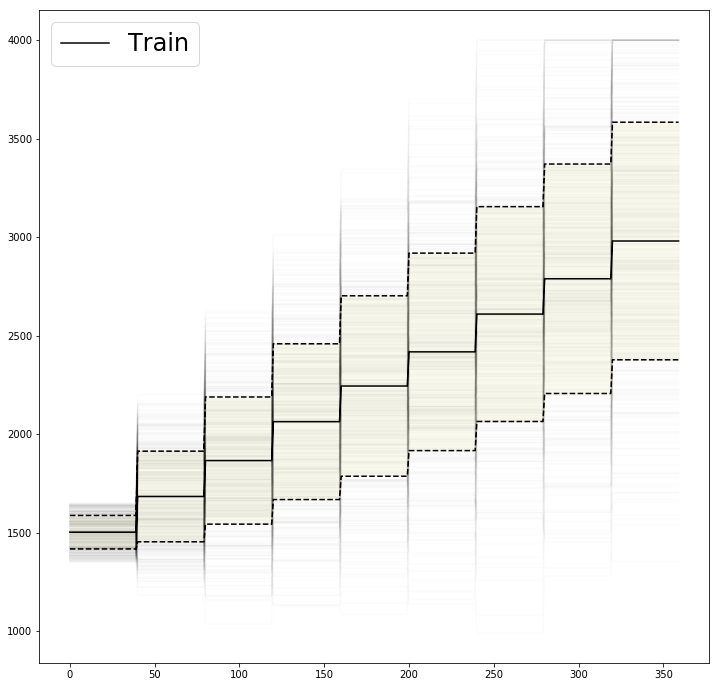

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
plot_velocity_models(ax, train_models_th, colors=["black",  "black", "beige"], legend="Train")
plt.legend(fontsize=24)

As we can see on this graph, where the individual velocity models are shown shaded in the background, the velocity models show a high diversity and a few models even have decreasing velocities with depth.

### Storing the individual models

Here we store the full velocity models for later forward-modeling as well as so-called labels, which are only the velocities in each layer.  
This will make for a much smaller dataset later on.

In [4]:
np.save(train_data_dir+'train_models.npy', train_models_th.numpy())

np.save(train_data_dir+'train_labels.npy', train_labels_th.numpy())


## Generating velocity models for the test set

We apply the same process for the test set models, changing only the random number seed as well as  
the total number of models to generate to $N=150$ models.

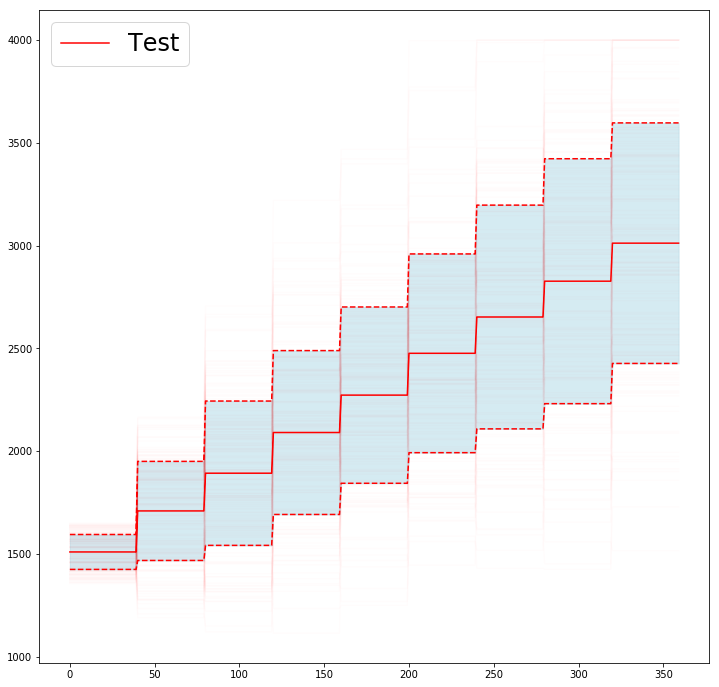

In [16]:
torch.manual_seed(test_data_seed)
torch.cuda.manual_seed_all(test_data_seed)

dVel0 = torch.distributions.Uniform(low=-150, high=150)
dVel =  torch.distributions.Uniform(low=-380, high=380)


test_models_th, test_labels_th = sample_model_N_times(dVel0, dVel, 
                                                      v0, dv_l_const, v_max, 
                                                      n_layers, dz, dx, ny, nz, 
                                                      N_test)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
plot_velocity_models(ax, test_models_th, colors=["red",  "red", "lightblue"], legend="Test")
plt.legend(fontsize=24)

### Storing the velocities of the test set to disk

In [6]:
np.save(test_data_dir+'test_models.npy', test_models_th.numpy())

np.save(test_data_dir+'test_labels.npy', test_labels_th.numpy())

## Comparing train and test sets

Here we compare the two datasets to make sure that the training and test sets follow the same data distribution.  
While we can see a small deviation in the mean of the curves and standard deviation, the overall trend is good and we cannot, as expected due to sampling from the same model, observe any obvious bias in training and test sets.

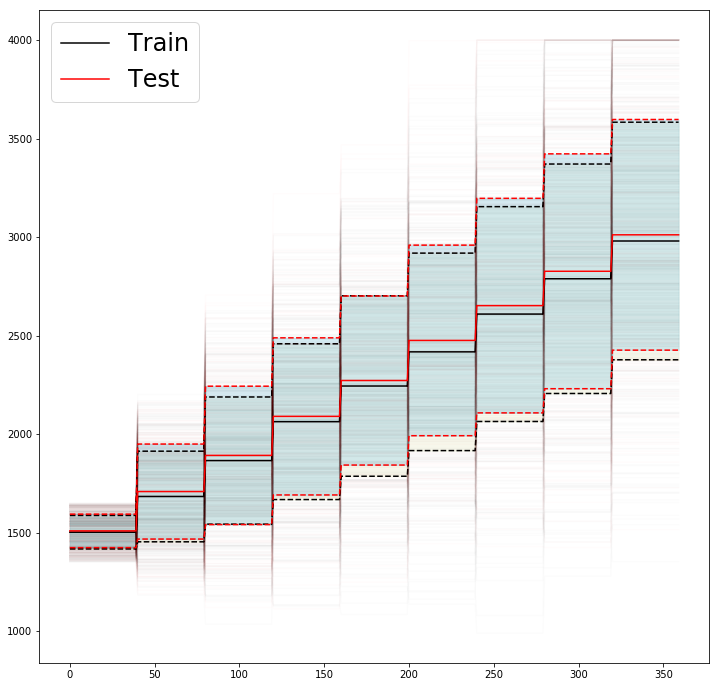

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

plot_velocity_models(ax, train_models_th, colors=["black",  "black", "beige"], legend="Train")
plot_velocity_models(ax, test_models_th, colors=["red",  "red", "lightblue"], legend="Test")

plt.legend(fontsize=24)

## Using Devito to compute forward-modeled waveforms

We now make use of [Devito](https://www.devitoproject.org/), [ArXiv](http://arxiv.org/abs/1807.03032) which is a blazing fast _Symbolic Finite-Difference Computation Framework_ to compute solutions of the acoustic wavefield for the source receiver configuration defined in the original paper by Roeth and Tarantola.

Luckily, the authors of Devito recently published an extensive series of tutorials on how to use Devito for acoustic waveform forward-modeling for geophysical applications which, if you haven't read yet, you should definitely check out [here](https://github.com/opesci/devito/tree/master/examples/seismic/tutorials).

The following section outlines the main parts of the code that is located in ```forward_model/devito/examples/seismic/acoustic/acoustic_examples.py```, which you can use to run Devito to model the acoustic amplitudes.

The main steps that are needed are:
- Defining a Source Wavelet; in this case we use a Ricker wavelet with 8 Hz peak frequency as in the paper
- Load a velocity model that we want to forward model
- Define a Devito ```Model``` object that receives our p-wave velocities
- Create an ```AcquisitionGeometry``` object that takes in the receiver and source coordinates, as well as the wavelet type.
- Instantiate an ```AcousticWaveSolver``` object that allows us to 
- Call ```.forward``` on our  ```AcousticWaveSolver``` which returns our recorded traces

That's all! 

If you're an expert user, you may choose to install Devito locally.
For everyone else, I highly recommend you to use the provided [Docker](https://www.docker.com/) container.

Simply run one of the following to create the training and test waveforms. 
Takes around two hours on 4 CPUs. I've set Devito to use OpenMP (parallel execution) for you.

Follow these steps to create the training and test waveforms:

- Change into the ```forward_model\devito``` directory
- Use docker-compose to create a container that will run the forward models:  
```docker-compose run devito /bin/bash```
- Run the following to generate the waveforms for the train set:  
```python ./examples/seismic/acoustic/acoustic_example.py --input ./data/train/train_models.npy --output ./data/train/train_amplitudes_devito.npy```
- Run the following to generate the waveforms for the test set:  
```python ./examples/seismic/acoustic/acoustic_example.py --input ./data/test/test_models.npy --output ./data/test/test_amplitudes_devito.npy```

In [ ]:
#This is dummy code which will not run in your standard jupyter notebook.

#Simulation Parameters
tn = 2710.0 #Total Recording Time 2.71 seconds
num_samples = 271 #Number of samples per trace, results are resampled to this number of samples, 10 ms

#Geometry Parameters
shape = tuple([500, 360]) #Total Number of Grid-Blocks
spacing = tuple([5.0, 5.0]) #meters
dist_first_receiver = 140. #meters
spacing_receivers = 90. #meters
num_receivers = 20

#Wavelet Parameters - Ricker Wavelet
peak_frequency = 8. #Hz

vp = np.load("/data/train/train_models.npy").astype(np.float32)/1000. #convert from m/s to km/s

model = Model(vp=vp.T, shape=shape, spacing=spacing, nbpml=nbpml)

# Source and receiver geometries
src_coordinates = np.zeros((1, len(spacing)))    
rec_coordinates = np.zeros((num_receivers, len(spacing)))
rec_coordinates[:, 0] = dist_first+rec_spacing*np.array(range(num_rec))

#Create the acquisition geometry from source and receiver corrdinates as well as defining the source wavelet
geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0=0.0, tn=tn, src_type='Ricker', f0=peak_freq/1000.)

# Create solver object to provide relevant operators
solver = AcousticWaveSolver(model, geometry, kernel=kernel, space_order=space_order, **kwargs)

#Forward Model the Wavefield and obtain the recorded seismic traces: rec
rec, u, summary = solver.forward()

## Inspecting the forward modelled waveforms

Now that we've used Devito to create the forward models of our acoustic waveforms, we should load them back and see what they actually look like. Again, I've made some helper plots to aid us in inspecting the data.  

We plot here the recorded waveforms from a single acoustic source on a graph of _Recording Time_ in \[ms\] versus the _Seismic Amplitude_ at each acoustic recording station (offset trace).

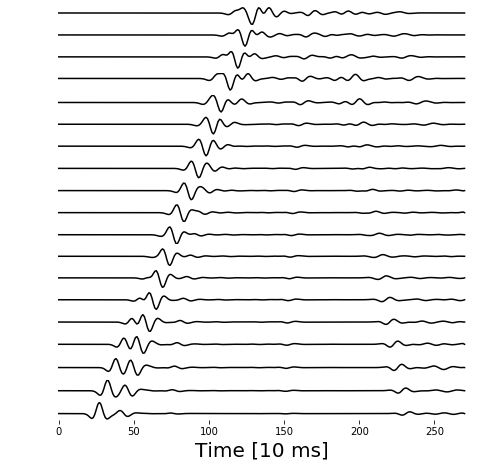

In [26]:
n_samples = 271
n_recorders = 20

amplitudes = np.load("./data/train/train_amplitudes_devito.npy")

amplitude_data = amplitudes[0].reshape((n_samples, n_recorders))
fig = plt.figure(figsize=(8, 8))
plot_wiggle_traces(fig, amplitude_data, n_recorders)

## Wrap up and Conclusions

Wrapping up this second instance of the blog series on Roeth and Tarantola's paper, I find it amazing that we have these computational tools available to us nowadays and that the computational power of desktops has advanced so much, that we can run these simulations in a few minutes. This makes me wonder what computational setup Roeth and Tarantola must have had in the 1990's to perform these kinds of modeling excercises.

Next time, we will get into the whole deep-learning shebang and reimplement the original Neural Network used, train it on our waveforms to output velocities and investigate how well we can actually perform the task of predicting velocities from just the raw amplitudes.